In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import json
import time
import datetime

<h2>DeepAR - Kaggle Bike Sharing Demand Dataset</h2>
<h4>Prepare Bike Rental Data for DeepAR training</h4>  
<quote>We will store the total rental count, registered rental count, and casual rental count data as a time series.</quote>
<quote>For each of the targets <b>total, registered, casual</b>, following JSON is structured as: Start Time, Array of target values, optional dynamic features and categories</quote>
<quote>Frequency of time series data (for example, hourly, daily, monthly and so forth) is specified using hyperparameter</quote>

<h4>To download original dataset, sign-in and download from this link: https://www.kaggle.com/c/bike-sharing-demand/data</h4>
<br>
None of these features are used: ['season', 'holiday', 'workingday', 'weather', 'temp',
       'atemp', 'humidity', 'windspeed']<br>
       
Start Time From: ['datetime'] <br>
Target Feature: [<b>'count','registered','casual'</b>]<br>
Frequency: 'Hourly' <br>

Objective: <quote>You are provided hourly rental data spanning two years. For this competition, the training set is comprised of the first 19 days of each month, while the test set is the 20th to the end of the month. You must predict the total count of bikes rented during each hour covered by the test set, using only information available prior to the rental period (Ref: Kaggle.com)</quote>

In [2]:
# controls if categroies are included in training or not

target_values = ['count','registered','casual']

with_categories = False

In [3]:
# set datetime column as index to work with data based on Date/Time

df = pd.read_csv('train.csv', parse_dates=['datetime'], index_col='datetime')
df_test = pd.read_csv('test.csv', parse_dates=['datetime'],index_col='datetime')

In [4]:
df.shape[0]

10886

In [5]:
df_test.shape[0]

6493

In [6]:
df.head(5)

,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
datetime,,,,,,,,,,,
2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2011-01-01 02:00:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
2011-01-01 03:00:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
2011-01-01 04:00:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


In [8]:
df.index.min(), df.index.max()

(Timestamp('2011-01-01 00:00:00'), Timestamp('2012-12-19 23:00:00'))

In [9]:
df_test.index.min(), df_test.index.max()

(Timestamp('2011-01-20 00:00:00'), Timestamp('2012-12-31 23:00:00'))

<Axes: xlabel='datetime'>

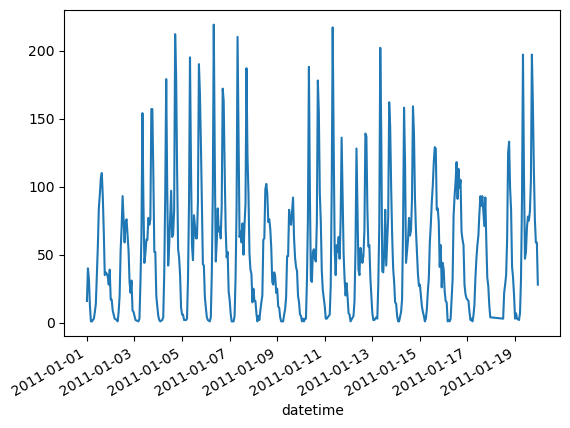

In [13]:
df.loc['2011-01','count'].plot()

<Axes: xlabel='datetime'>